<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/part-2/Neural_network_face_classificaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Часть 2**
***Решение задачи классификации с использованием нейронных сетей.***

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple
from google.colab import drive
from sklearn.externals import joblib 
from PIL import Image, ImageDraw

# подключение гугл-диска
drive.mount('/content/drive')

RANDOM_SEED = 42
PATH = '/content/drive/My Drive/Курсач/files/'

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Mounted at /content/drive


In [58]:
#Загрузим всё необходимое
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
import time

Faces = namedtuple('Faces', 'img is_face filename rect')
Rectangle = namedtuple('Rectangle', 'x y w h')

all_features = joblib.load(os.path.join(PATH,'all_features.pkl'))
#x_test = joblib.load(os.path.join(PATH,'x_test.pkl'))
x_train = joblib.load(os.path.join(PATH,'x_train.pkl'))
y_train = joblib.load(os.path.join(PATH,'y_train.pkl'))
y_test = joblib.load(os.path.join(PATH,'y_test.pkl'))
time_of_features_creat = joblib.load(os.path.join(PATH,'time_of_features_creat.pkl'))

features_list = ['Haars features', 'Matrix features','Matrix + PCA features']
categories = ['hf_train', 'mf_train','pca_train', 'hf_test', 'mf_test', 'pca_test']
net_cols = ['fully_con_net_cpu', 'fully_con_net_gpu','convol_net_cpu', 'convol_net_gpu']

net_time_df = pd.DataFrame(index = categories, columns = net_cols)
net_accuracy = pd.DataFrame(features_list, index=['1', '2', '3'], columns=['features'])

In [60]:
#сразу приплюсуем время на создание самих признаков
for i, rows in enumerate(categories):
    if rows[:2] == 'mf':
        net_time_df.loc[rows] = time_of_features_creat[i]
    else:
        net_time_df.loc[rows][0]= net_time_df.loc[rows][1] = time_of_features_creat[i]

print('Time for feature creating')
net_time_df[:]

Time for feature creating


,fully_con_net_cpu,fully_con_net_gpu,convol_net_cpu,convol_net_gpu
hf_train,0.00165963,0.00165963,NaN,NaN
mf_train,1.4514e-05,1.4514e-05,1.4514e-05,1.4514e-05
pca_train,1.45342e-05,1.45342e-05,NaN,NaN
hf_test,0.00163778,0.00163778,NaN,NaN
mf_test,1.33948e-05,1.33948e-05,1.33948e-05,1.33948e-05
pca_test,1.43161e-05,1.43161e-05,NaN,NaN


#Полносвязная нейронная сеть

Во 2 части предметом исследования станут нейронные сети. А именно мы хотим провести сравнительный анализ для методов машинного обучения и нейронных сетей в задаче классификации лиц на изображении. Для этого возьмём все типы признаков из предыдущей части, а критериями сравнения станут точность, время обучения и предсказания, а также объём занимаемой памяти обученных моделей.

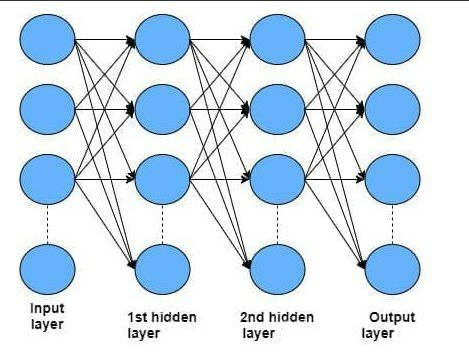  

Для построения архитектуры сети, нам необходимо определить количество слоёв и нейронов, а также задать функцию потерь, оптимизационную функцию и тд... Подбор параметров осуществим эмпирическим путём.  
  
   
**P.S. Построенную полносвязную сеть будем описывать как `a / x_1 / ... / x_n / b`, где `a`, `b` - число нейронов входного слоя и выходного слоя, а `x_i` - число нейронов скрытых слоёв. Результаты экспериментов при построении архитектур можно найти здесь: https://docs.google.com/spreadsheets/d/1Qvn6k-yyfEuRum9eUxRetVPQpU6imFPau3qaQrLEOYc/edit?usp=sharing**  
  
  
Проведём эксперименты для полносвязной сети со следующими параметрами:



> Схема сети: `len(features)/70/35/2 `    
> Функция активации: `sigmoid  `  
> Функция потерь: `CrossEntropyLoss`  
> Оптимизационная функция: `Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)`




In [61]:
class Net(nn.Module):
    def __init__(self, input_len):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_len, 70)
        self.fc2 = nn.Linear(70, 35)
        self.fc3 = nn.Linear(35, 2)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.sigmoid(self.fc3(out))
        return out

#Свёрточная нейронная сеть
Прежде чем, перейти к описанию самой сети, сразу следует отметить, что работать мы будем только с исходным матричным изображением, тк "вытягивать" вектора размеров 1*n нет смысла.  




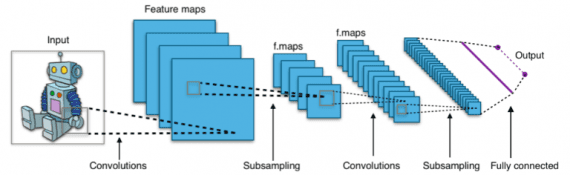


Проведём эксперименты для свёрточной сети со следующими параметрами:

> Схема сети:
>    *   1 Слой: свёртка + пуллинг (потом дописать выходные размеры и прочее)
>    *   2 Слой: свёртка + пуллинг (-/\/\-)  
>    *   Использование Dropout для лучшего обучения
>    *   Линейные полносвязные слои: 4\*64/32/2


> Функция активации: `sigmoid  `  
> Функция потерь: `CrossEntropyLoss`  
> Оптимизационная функция: `Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)`




In [62]:
class ConvNet(nn.Module): 
    def __init__(self): 
         super(ConvNet, self).__init__() 
         self.layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
         self.layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

         self.drop_out = nn.Dropout() 
         self.fc1 = nn.Linear(in_features= 2*2*64, out_features=64)
         self.fc2 = nn.Linear(in_features=64, out_features=32)
         self.fc3 = nn.Linear(in_features=32, out_features=2)
    
    def forward(self, x):
         out = F.relu(F.max_pool2d(self.layer1(x), 3))
         out = F.relu(F.max_pool2d(self.layer2(out), 2))
         out = self.drop_out(out) 
         out = out.view(out.size(0), -1)
         out = F.relu(self.fc1(out))
         out = F.relu(self.fc2(out))
         out = F.sigmoid(self.fc3(out))
         return out

#Обучение и тестирование
##Этап 1. Обучение
На данном этапе мы будем делать запускать обучение для каждой из сетей в зависимости от типа признаков и типа процессора.  
Критерием останова будет  значение `MAX_ITER` для цикла `epoch`. Также если в течение 100 эпох на `validate` выборке у нас не будет изменяться значение `accuracy`, то это тоже будет точкой остановки.  
*Примечание: для реализации этого пункта, для валидации будем заранее отделять 25% от тренировочной выборки.*  
Для анализа процесса обучения построим графики зависимости (от числа эпох) для:


*   `accuracy` на `test` выборке
*   `accuracy` на `validation` выборке
*    значение `loss`-функции

Для данного этапа будем измерять время, затраченное на создание признаков, перенос данных на графический процессор(если это было) + время обучения всей сети.

##Этап 2. Тестирование
Прогоним  тестовые выборки через обученные сети, а потом посмотрим на время, затраченное на классификацию одного элемента выборки

In [63]:
def plot_graphic(y_points, title):
    x_points = lambda x: np.arange(0,len(y_points[x]))

    plt.figure(figsize=(20, 10))
    plt.title(title, fontsize=18, fontname='Times New Roman')
    plt.xlabel('Epoch',fontsize=16, fontname='Times New Roman')
    plt.ylabel('Score',fontsize=16, fontname='Times New Roman')
    plt.plot(x_points(0), y_points[0], color='#fb607f', linestyle='-')
    if len(y_points) > 1:
        plt.plot(x_points(1), y_points[1], color='#906bff', linestyle='-')
        plt.plot(x_points(2), y_points[2], color='#c71585', linestyle='-')
        plt.legend(features_list, loc='center', shadow=True,fontsize=18)
    else:  plt.legend(['matrix'], loc='center', shadow=True,fontsize=18)
    plt.show()

In [64]:
def nn_training(x_train, y_train, is_gpu, loop, time_df, feature_type, index,
                y_points_acc, y_points_loss, y_points_val, net_type):
    
    #Зафиксируем всё, что фиксируется, чтобы получать одинаковые результаты между запусками
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    
    if (net_type == 'convolution'):
        net = ConvNet()
        net_index = 1
    else:
        net = Net(len(x_train[0]))
        net_index = 0

    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    #сделаем массивы точек для построения гафиков accuracy при обучении
    y_points_for_one, y_loss_points_for_one, y_val_points_for_one = [], [], []

    t0 = time.time()

    #поделим ещё немного x_train, чтобы сделать  x_validate
    x_train, x_validate  = np.split(x_train, [int(0.75*len(x_train))])
    y_train, y_validate  = np.split(y_train, [int(0.75*len(y_train))])

    x_train_torch, x_validate_torch = torch.from_numpy(x_train).float(), torch.from_numpy(x_validate).float()
    y_train_torch,y_validate_torch = torch.from_numpy(y_train), torch.from_numpy(y_validate)

    if net_type == 'convolution':
        x_train_torch = torch.unsqueeze(torch.reshape(x_train_torch, (len(x_train_torch), 25, 25)), 1)
        x_validate_torch = torch.unsqueeze(torch.reshape(x_validate_torch, (len(x_validate_torch), 25, 25)), 1)

    #будем проверять на 2-х процессорах
    if is_gpu == 1:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")
    net.to(device)

    x_train_torch, y_train_torch = x_train_torch.to(device), y_train_torch.to(device)
    x_validate_torch, y_validate_torch = x_validate_torch.to(device), y_validate_torch.to(device)
    print('\n', net_type, ' network')
    print('Feature type: ', feature_type)
    print(device)

    for epoch in range(loop): # loop
        optimizer.zero_grad()
        output = net(x_train_torch)
        loss = criterion(output, y_train_torch)
        loss.backward()
        #clip_grad_norm(net.parameters(), 0.01)
        optimizer.step()

        with torch.no_grad():
             validate_output = net(x_validate_torch)

        y_loss_points_for_one.append(loss.item())
        y_points_for_one.append(accuracy_score(y_train, torch.argmax(output.data, dim = 1 ).cpu()))
        y_val_points_for_one.append(accuracy_score(y_validate, torch.argmax(validate_output.data, dim = 1 ).cpu()))

        if len(y_val_points_for_one) >=100 and np.all(y_val_points_for_one[-100:] == y_val_points_for_one[-1]):
            print('Early stopping! No changes in last 100 epoch for validation samples! Epoch: ', epoch)
            break
    t = time.time()
    print('Last validation accuracy: ', y_val_points_for_one[-1])
    print('Last train accuracy: ', y_points_for_one[-1])
    print('Loss: ', y_loss_points_for_one[-1])

    #сохраним обученную сеть        
    torch.save(net.state_dict(), os.path.join(PATH, 'Networks', feature_type + '_' + net_type + '_neural_net.pth'))
    
    #заполним табличку с временем
    time_df.loc[categories[index]][net_cols[is_gpu + 2 * net_index]] += (t - t0)

    #нарисуем график 
    if is_gpu == 1:
        y_points_acc.append(y_points_for_one)
        y_points_loss.append(y_loss_points_for_one)
        y_points_val.append(y_val_points_for_one)
        if len(y_points_acc) == 3 or net_type == 'convolution':
            plot_graphic(y_points_val, 'Accuracy score for validation')
            plot_graphic(y_points_acc, 'Accuracy score for train')
            plot_graphic(y_points_loss, 'Loss')


In [65]:
def nn_test(x_test, is_gpu, feature_type, data_df, time_df, index, net_type):

    x_test_torch = torch.from_numpy(x_test).float()

    if (net_type == 'convolution'):
        net = ConvNet()
        net_index = 1
        x_test_torch = torch.unsqueeze(torch.reshape(x_test_torch, (len(x_test_torch), 25, 25)), 1)
    else:
        net = Net(len(x_test[0]))
        net_index = 0
    net.load_state_dict(torch.load(os.path.join(PATH, 'Networks', feature_type + '_' + net_type + '_neural_net.pth')))

    t0 = time.time()
    
    with torch.no_grad():
        output = net(x_test_torch)
        data_df[net_cols[is_gpu + 2 * net_index]] = torch.argmax(output.data, dim = 1)
    t = time.time()

    time_df.loc[categories[index]][net_cols[is_gpu + 2 * net_index]] += (t - t0)/len(x_test)

#Запуск

После инициализации всех необходимых функций, самое время ими воспользоваться:)  
Проводить эксперименты мы будем на 3-х признаках для полносвязной нейронной сети, и на исходной матрицы изображения 25*25 пикселей для свёрточной нейронной сети.  
Также попробуем позапускать весь процесс на двух типах процессора для оценки временных затрат каждого.


 fully_connected  network
Feature type:  hf
cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Early stopping! No changes in last 100 epoch for validation samples! Epoch:  6925
Last validation accuracy:  0.8258119175374188
Last train accuracy:  0.9088341617713511
Loss:  0.40470224618911743

 fully_connected  network
Feature type:  mf
cuda:0
Early stopping! No changes in last 100 epoch for validation samples! Epoch:  19890
Last validation accuracy:  0.8429822084157018
Last train accuracy:  0.9188507305317066
Loss:  0.3944237232208252

 fully_connected  network
Feature type:  mf_pca
cuda:0
Early stopping! No changes in last 100 epoch for validation samples! Epoch:  14658
Last validation accuracy:  0.8257554363174244
Last train accuracy:  0.9405972284982678
Loss:  0.3726615607738495


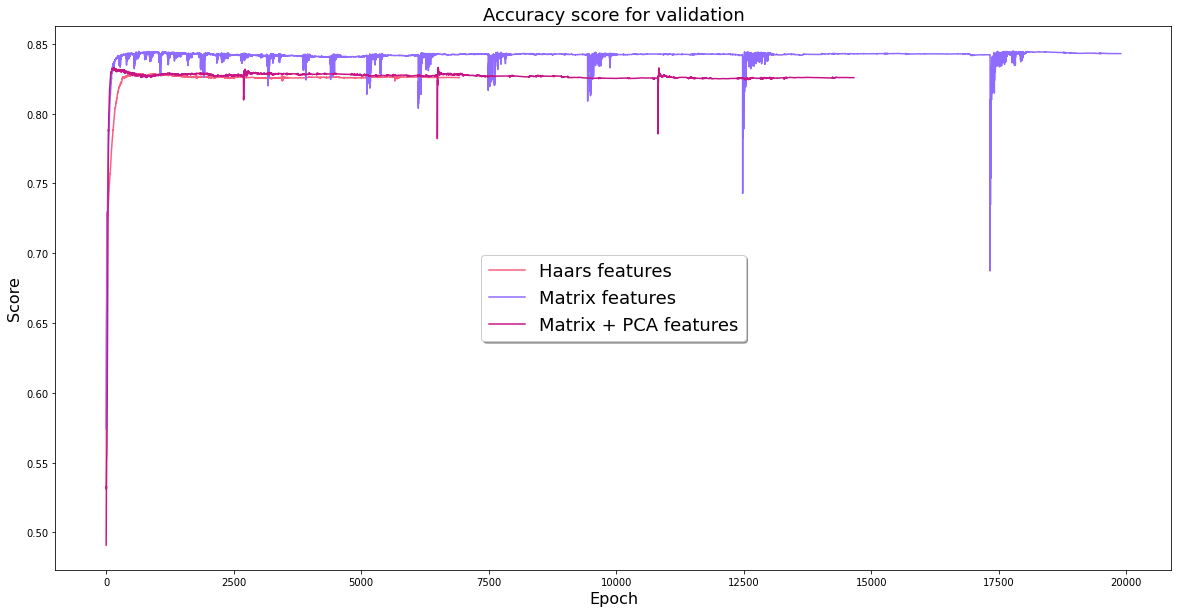

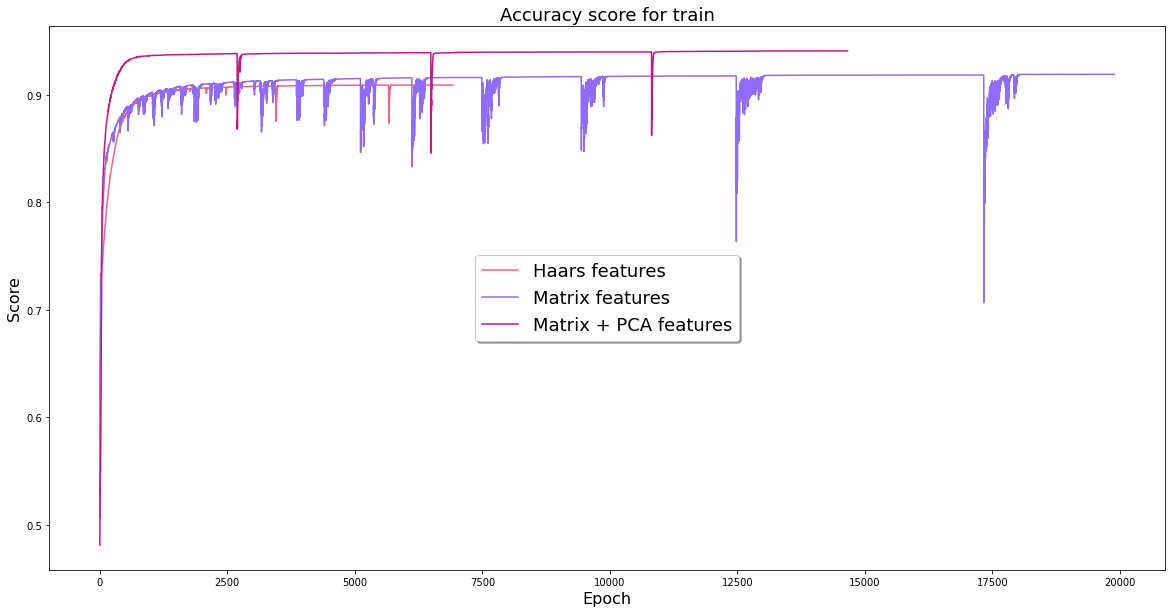

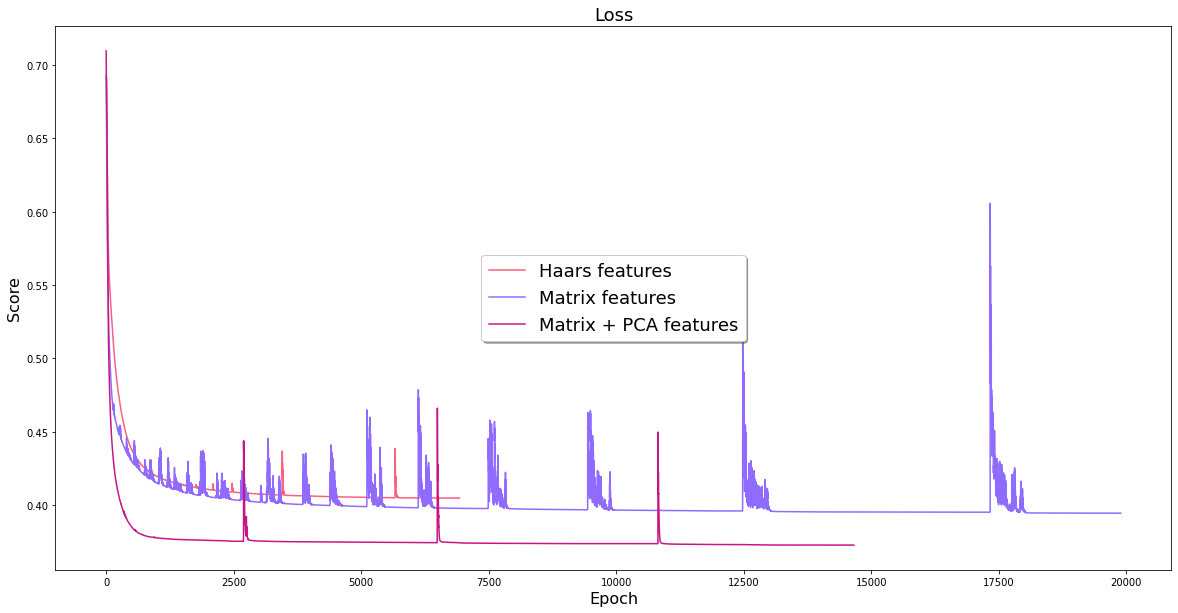

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 convolution  network
Feature type:  mf
cuda:0


In [ ]:
haars_net_df = pd.DataFrame(columns=net_cols[:2])
matrix_net_df = pd.DataFrame(columns=net_cols)
matrix_net_pca_df = pd.DataFrame(columns=net_cols[:2])
y_points_acc = []
y_points_loss = []
y_points_val = []

MAX_ITER = 50000

for is_gpu in range(1,2):
    nn_training(all_features[0], y_train, is_gpu, MAX_ITER, net_time_df, 'hf', 0, y_points_acc, y_points_loss, y_points_val, 'fully_connected')
    nn_test(all_features[3], is_gpu, 'hf', haars_net_df, net_time_df, 3, 'fully_connected')

    nn_training(all_features[1], y_train, is_gpu, MAX_ITER, net_time_df, 'mf', 1, y_points_acc, y_points_loss, y_points_val, 'fully_connected')
    nn_test(all_features[4], is_gpu, 'mf', matrix_net_df, net_time_df, 4, 'fully_connected') 

    nn_training(all_features[2], y_train, is_gpu, MAX_ITER, net_time_df, 'mf_pca', 2, y_points_acc, y_points_loss, y_points_val, 'fully_connected')
    nn_test(all_features[5], is_gpu, 'mf_pca', matrix_net_pca_df, net_time_df, 5, 'fully_connected')

    y_points_acc.clear(), y_points_loss.clear(), y_points_val.clear()
    nn_training(all_features[1], y_train, is_gpu, MAX_ITER, net_time_df, 'mf', 1, y_points_acc, y_points_loss, y_points_val, 'convolution')
    nn_test(all_features[4], is_gpu, 'mf', matrix_net_df, net_time_df, 4, 'convolution') 
    
haars_net_df.insert(0, 'y_test', y_test)
matrix_net_df.insert(0, 'y_test', y_test)
matrix_net_pca_df.insert(0, 'y_test', y_test)


In [ ]:
matrix_net_df[:]

In [ ]:
haars_net_df[:]

In [ ]:
net_time_df[:]

In [ ]:
#coxpaним датафреймы
haars_net_df.to_csv(os.path.join(PATH, 'Dataframes', 'haars_net_df.csv'))
matrix_net_df.to_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_df.csv'))
matrix_net_pca_df.to_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_pca_df.csv'))
net_time_df.to_csv(os.path.join(PATH, 'Dataframes', 'net_time_df.csv'))

#Анализ результатов
Посчитаем `accuracy` для проведённых выше экспериментов.  
P.S Поскольку тип процессора влияет только на производительность, то будем считать `accuracy` только для одного из них.

In [57]:
from pandas import read_csv

haars_net_df = read_csv(os.path.join(PATH, 'Dataframes', 'haars_net_df.csv')) 
matrix_net_df = read_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_df.csv')) 
matrix_net_pca_df = read_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_pca_df.csv')) 
net_time_df = read_csv(os.path.join(PATH, 'Dataframes', 'net_time_df.csv')) 

net_accuracy[net_cols[1]] = [accuracy_score(haars_net_df['y_test'], haars_net_df[net_cols[1]]),
                                    accuracy_score(matrix_net_df['y_test'], matrix_net_df[net_cols[1]]),
                                    accuracy_score(matrix_net_pca_df['y_test'], matrix_net_pca_df[net_cols[1]])]

net_accuracy[net_cols[3]] = [np.NaN, accuracy_score(matrix_net_df['y_test'], matrix_net_df[net_cols[3]]), np.NaN]                                   

net_accuracy[:]

,features,fully_con_net_gpu,convol_net_gpu
1,Haars features,0.568330,NaN
2,Matrix features,0.617597,0.508388
3,Matrix + PCA features,0.522028,NaN


#Примечание
пока всё запущено и посчитано только на gpu, тк для cnn нужно выбрать меньшую константу с итерациями, тк процесс идёт ну о-о-о-очень медленно, а точность в конце не очень-то и растёт:)